#### EL código de este cuaderno fue tomado del repositorio de Github https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/tree/main/notebooks/03_vae/03_vae_faces

# 🤪 Variational Autoencoders - CelebA Faces

In this notebook, we'll walk through the steps required to train your own variational autoencoder on the CelebA faces dataset

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

from utils import sample_batch, display

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

2024-07-29 10:50:31.624981: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## 0. Parameters <a name="parameters"></a>

In [2]:
#IMAGE_SIZE = 32
IMAGE_SIZE = 128

CHANNELS = 3

#BATCH_SIZE = 32 #Este batch size si funciona
BATCH_SIZE = 64 #Este batch size también funciona
#BATCH_SIZE = 128 # Mi ordenador no es capaz con un batch size tan grande
#BATCH_SIZE = 256 #Mi ordenador no es capaz con un batch size tan grande
#BATCH_SIZE = 512 #Mi ordenador no es capaz con un batch size tan grande

NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
#EPOCHS = 10
EPOCHS = 65

BETA = 2000
LOAD_MODEL = True

## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "/media/roger/Datos/asignaturas_master/tfm/datasetCelebA/archive/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


2024-07-29 10:50:36.760986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-29 10:50:36.836972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-29 10:50:36.837082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-29 10:50:36.838450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [4]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

In [5]:
train_sample = sample_batch(train)

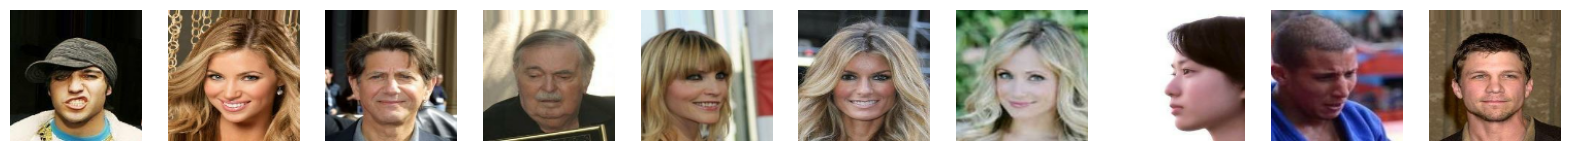

In [6]:
# Show some faces from the training set
display(train_sample, cmap=None)

## 2. Build the variational autoencoder <a name="build"></a>

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 128)  3584        ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [9]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 8192)              1646592   
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      147584    
 nspose)                                                     

In [10]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [11]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [12]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [14]:
# Load old weights if required #Puede haber problemas al cargar los pesos si la GPU está llena
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

2024-07-29 10:50:37.898184: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./models/vae: FAILED_PRECONDITION: models/vae; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2024-07-29 10:50:39.006159: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2024-07-29 10:50:41.312702: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-07-29 10:50:41.312712: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-07-29 10:50:41.312739: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-07-29 10:50:42.332545: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] Ten

1/1 [==============================] - 5s 5s/step


In [15]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/65
3166/3166 [==============================] - ETA: 0s - loss: 63.0210 - reconstruction_loss: 44.6162 - kl_loss: 18.3812

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 542s 171ms/step - loss: 63.0210 - reconstruction_loss: 44.6162 - kl_loss: 18.3812
Epoch 2/65
3166/3166 [==============================] - ETA: 0s - loss: 63.0130 - reconstruction_loss: 44.6076 - kl_loss: 18.3798

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 63.0130 - reconstruction_loss: 44.6076 - kl_loss: 18.3798
Epoch 3/65
3166/3166 [==============================] - ETA: 0s - loss: 63.0064 - reconstruction_loss: 44.5868 - kl_loss: 18.3869

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 63.0064 - reconstruction_loss: 44.5868 - kl_loss: 18.3869
Epoch 4/65
3166/3166 [==============================] - ETA: 0s - loss: 63.0053 - reconstruction_loss: 44.5393 - kl_loss: 18.4126

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 63.0053 - reconstruction_loss: 44.5393 - kl_loss: 18.4126
Epoch 5/65
3166/3166 [==============================] - ETA: 0s - loss: 62.9779 - reconstruction_loss: 44.5391 - kl_loss: 18.4010

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.9779 - reconstruction_loss: 44.5391 - kl_loss: 18.4010
Epoch 6/65
3166/3166 [==============================] - ETA: 0s - loss: 62.9463 - reconstruction_loss: 44.4986 - kl_loss: 18.4040

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.9463 - reconstruction_loss: 44.4986 - kl_loss: 18.4040
Epoch 7/65
3166/3166 [==============================] - 543s 171ms/step - loss: 62.9553 - reconstruction_loss: 44.4908 - kl_loss: 18.4152
Epoch 8/65
3166/3166 [==============================] - ETA: 0s - loss: 62.9329 - reconstruction_loss: 44.4697 - kl_loss: 18.4125

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.9329 - reconstruction_loss: 44.4697 - kl_loss: 18.4125
Epoch 9/65
3166/3166 [==============================] - ETA: 0s - loss: 62.9263 - reconstruction_loss: 44.4351 - kl_loss: 18.4353

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.9263 - reconstruction_loss: 44.4351 - kl_loss: 18.4353
Epoch 10/65
3166/3166 [==============================] - ETA: 0s - loss: 62.8717 - reconstruction_loss: 44.4184 - kl_loss: 18.4245

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 544s 172ms/step - loss: 62.8717 - reconstruction_loss: 44.4184 - kl_loss: 18.4245
Epoch 11/65
3166/3166 [==============================] - ETA: 0s - loss: 62.8612 - reconstruction_loss: 44.3864 - kl_loss: 18.4419

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.8611 - reconstruction_loss: 44.3864 - kl_loss: 18.4419
Epoch 12/65
3166/3166 [==============================] - ETA: 0s - loss: 62.8175 - reconstruction_loss: 44.3636 - kl_loss: 18.4362

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 544s 172ms/step - loss: 62.8175 - reconstruction_loss: 44.3636 - kl_loss: 18.4362
Epoch 13/65
3166/3166 [==============================] - 542s 171ms/step - loss: 62.8467 - reconstruction_loss: 44.3541 - kl_loss: 18.4474
Epoch 14/65
3166/3166 [==============================] - ETA: 0s - loss: 62.8459 - reconstruction_loss: 44.3323 - kl_loss: 18.4567

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 544s 172ms/step - loss: 62.8459 - reconstruction_loss: 44.3323 - kl_loss: 18.4567
Epoch 15/65
3166/3166 [==============================] - ETA: 0s - loss: 62.8081 - reconstruction_loss: 44.2932 - kl_loss: 18.4677

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 544s 172ms/step - loss: 62.8081 - reconstruction_loss: 44.2932 - kl_loss: 18.4677
Epoch 16/65
3166/3166 [==============================] - ETA: 0s - loss: 62.7950 - reconstruction_loss: 44.2785 - kl_loss: 18.4702

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 542s 171ms/step - loss: 62.7950 - reconstruction_loss: 44.2785 - kl_loss: 18.4702
Epoch 17/65
3166/3166 [==============================] - ETA: 0s - loss: 62.7636 - reconstruction_loss: 44.2540 - kl_loss: 18.4826

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 542s 171ms/step - loss: 62.7635 - reconstruction_loss: 44.2540 - kl_loss: 18.4826
Epoch 18/65
3166/3166 [==============================] - 539s 170ms/step - loss: 62.7670 - reconstruction_loss: 44.2482 - kl_loss: 18.4883
Epoch 19/65
3166/3166 [==============================] - ETA: 0s - loss: 62.7488 - reconstruction_loss: 44.2171 - kl_loss: 18.4909

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 542s 171ms/step - loss: 62.7488 - reconstruction_loss: 44.2171 - kl_loss: 18.4909
Epoch 20/65
3166/3166 [==============================] - ETA: 0s - loss: 62.7400 - reconstruction_loss: 44.1937 - kl_loss: 18.5062

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 542s 171ms/step - loss: 62.7400 - reconstruction_loss: 44.1937 - kl_loss: 18.5062
Epoch 21/65
3166/3166 [==============================] - ETA: 0s - loss: 62.7312 - reconstruction_loss: 44.1747 - kl_loss: 18.5058

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 542s 171ms/step - loss: 62.7312 - reconstruction_loss: 44.1747 - kl_loss: 18.5058
Epoch 22/65
3166/3166 [==============================] - ETA: 0s - loss: 62.7349 - reconstruction_loss: 44.1549 - kl_loss: 18.5255

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 541s 171ms/step - loss: 62.7349 - reconstruction_loss: 44.1549 - kl_loss: 18.5255
Epoch 23/65
3166/3166 [==============================] - ETA: 0s - loss: 62.6864 - reconstruction_loss: 44.1358 - kl_loss: 18.5255

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 542s 171ms/step - loss: 62.6864 - reconstruction_loss: 44.1358 - kl_loss: 18.5255
Epoch 24/65
3166/3166 [==============================] - ETA: 0s - loss: 62.6936 - reconstruction_loss: 44.1255 - kl_loss: 18.5321

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 542s 171ms/step - loss: 62.6936 - reconstruction_loss: 44.1255 - kl_loss: 18.5321
Epoch 25/65
3166/3166 [==============================] - 542s 171ms/step - loss: 62.6976 - reconstruction_loss: 44.1365 - kl_loss: 18.5292
Epoch 26/65
3166/3166 [==============================] - ETA: 0s - loss: 62.6738 - reconstruction_loss: 44.1010 - kl_loss: 18.5350

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.6738 - reconstruction_loss: 44.1010 - kl_loss: 18.5350
Epoch 27/65
3166/3166 [==============================] - ETA: 0s - loss: 62.6618 - reconstruction_loss: 44.0883 - kl_loss: 18.5333

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.6618 - reconstruction_loss: 44.0883 - kl_loss: 18.5333
Epoch 28/65
3166/3166 [==============================] - ETA: 0s - loss: 62.6473 - reconstruction_loss: 44.0822 - kl_loss: 18.5266

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.6473 - reconstruction_loss: 44.0822 - kl_loss: 18.5266
Epoch 29/65
3166/3166 [==============================] - 543s 172ms/step - loss: 62.6746 - reconstruction_loss: 44.0902 - kl_loss: 18.5361
Epoch 30/65
3166/3166 [==============================] - ETA: 0s - loss: 62.6522 - reconstruction_loss: 44.0592 - kl_loss: 18.5481

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.6522 - reconstruction_loss: 44.0592 - kl_loss: 18.5481
Epoch 31/65
3166/3166 [==============================] - ETA: 0s - loss: 62.6283 - reconstruction_loss: 44.0440 - kl_loss: 18.5496

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.6283 - reconstruction_loss: 44.0440 - kl_loss: 18.5496
Epoch 32/65
3166/3166 [==============================] - ETA: 0s - loss: 62.6124 - reconstruction_loss: 44.0160 - kl_loss: 18.5494

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.6124 - reconstruction_loss: 44.0160 - kl_loss: 18.5494
Epoch 33/65
3166/3166 [==============================] - ETA: 0s - loss: 62.5899 - reconstruction_loss: 44.0097 - kl_loss: 18.5535

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.5899 - reconstruction_loss: 44.0097 - kl_loss: 18.5535
Epoch 34/65
3166/3166 [==============================] - ETA: 0s - loss: 62.6044 - reconstruction_loss: 44.0096 - kl_loss: 18.5517

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.6044 - reconstruction_loss: 44.0096 - kl_loss: 18.5517
Epoch 35/65
3166/3166 [==============================] - ETA: 0s - loss: 62.6210 - reconstruction_loss: 43.9991 - kl_loss: 18.5605

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.6210 - reconstruction_loss: 43.9991 - kl_loss: 18.5605
Epoch 36/65
3166/3166 [==============================] - ETA: 0s - loss: 62.5801 - reconstruction_loss: 43.9957 - kl_loss: 18.5571

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.5801 - reconstruction_loss: 43.9957 - kl_loss: 18.5571
Epoch 37/65
3166/3166 [==============================] - ETA: 0s - loss: 62.5622 - reconstruction_loss: 43.9753 - kl_loss: 18.5445

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 545s 172ms/step - loss: 62.5622 - reconstruction_loss: 43.9753 - kl_loss: 18.5445
Epoch 38/65
3166/3166 [==============================] - 543s 172ms/step - loss: 62.5625 - reconstruction_loss: 43.9684 - kl_loss: 18.5604
Epoch 39/65
3166/3166 [==============================] - 544s 172ms/step - loss: 62.6010 - reconstruction_loss: 43.9717 - kl_loss: 18.5711
Epoch 40/65
3166/3166 [==============================] - ETA: 0s - loss: 62.5373 - reconstruction_loss: 43.9497 - kl_loss: 18.5664

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 546s 173ms/step - loss: 62.5373 - reconstruction_loss: 43.9497 - kl_loss: 18.5664
Epoch 41/65
3166/3166 [==============================] - ETA: 0s - loss: 62.5551 - reconstruction_loss: 43.9277 - kl_loss: 18.5765

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 546s 172ms/step - loss: 62.5551 - reconstruction_loss: 43.9277 - kl_loss: 18.5765
Epoch 42/65
3166/3166 [==============================] - 544s 172ms/step - loss: 62.5381 - reconstruction_loss: 43.9418 - kl_loss: 18.5712
Epoch 43/65
3166/3166 [==============================] - ETA: 0s - loss: 62.5408 - reconstruction_loss: 43.9228 - kl_loss: 18.5718

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 546s 172ms/step - loss: 62.5408 - reconstruction_loss: 43.9228 - kl_loss: 18.5718
Epoch 44/65
3166/3166 [==============================] - ETA: 0s - loss: 62.5459 - reconstruction_loss: 43.9284 - kl_loss: 18.5565

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 546s 172ms/step - loss: 62.5459 - reconstruction_loss: 43.9284 - kl_loss: 18.5565
Epoch 45/65
3166/3166 [==============================] - ETA: 0s - loss: 62.5095 - reconstruction_loss: 43.9010 - kl_loss: 18.5711

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 546s 172ms/step - loss: 62.5095 - reconstruction_loss: 43.9010 - kl_loss: 18.5711
Epoch 46/65
3166/3166 [==============================] - ETA: 0s - loss: 62.4875 - reconstruction_loss: 43.8833 - kl_loss: 18.5877

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 546s 172ms/step - loss: 62.4875 - reconstruction_loss: 43.8833 - kl_loss: 18.5877
Epoch 47/65
3166/3166 [==============================] - ETA: 0s - loss: 62.5068 - reconstruction_loss: 43.8880 - kl_loss: 18.5772

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 546s 172ms/step - loss: 62.5068 - reconstruction_loss: 43.8880 - kl_loss: 18.5772
Epoch 48/65
3166/3166 [==============================] - ETA: 0s - loss: 62.4800 - reconstruction_loss: 43.8639 - kl_loss: 18.5932

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 546s 172ms/step - loss: 62.4800 - reconstruction_loss: 43.8639 - kl_loss: 18.5932
Epoch 49/65
3166/3166 [==============================] - 544s 172ms/step - loss: 62.4900 - reconstruction_loss: 43.8716 - kl_loss: 18.5915
Epoch 50/65
3166/3166 [==============================] - ETA: 0s - loss: 62.4673 - reconstruction_loss: 43.8614 - kl_loss: 18.5787

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 546s 172ms/step - loss: 62.4673 - reconstruction_loss: 43.8614 - kl_loss: 18.5787
Epoch 51/65
3166/3166 [==============================] - 544s 172ms/step - loss: 62.4982 - reconstruction_loss: 43.8630 - kl_loss: 18.5804
Epoch 52/65
3166/3166 [==============================] - ETA: 0s - loss: 62.4688 - reconstruction_loss: 43.8493 - kl_loss: 18.5748

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 546s 173ms/step - loss: 62.4688 - reconstruction_loss: 43.8493 - kl_loss: 18.5748
Epoch 53/65
3166/3166 [==============================] - 544s 172ms/step - loss: 62.4450 - reconstruction_loss: 43.8489 - kl_loss: 18.5802
Epoch 54/65
3166/3166 [==============================] - 544s 172ms/step - loss: 62.4560 - reconstruction_loss: 43.8493 - kl_loss: 18.5820
Epoch 55/65
3166/3166 [==============================] - ETA: 0s - loss: 62.4293 - reconstruction_loss: 43.8143 - kl_loss: 18.5888

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 547s 173ms/step - loss: 62.4293 - reconstruction_loss: 43.8143 - kl_loss: 18.5888
Epoch 56/65
3166/3166 [==============================] - ETA: 0s - loss: 62.4211 - reconstruction_loss: 43.8157 - kl_loss: 18.5836

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 547s 173ms/step - loss: 62.4211 - reconstruction_loss: 43.8157 - kl_loss: 18.5836
Epoch 57/65
3166/3166 [==============================] - 544s 172ms/step - loss: 62.4490 - reconstruction_loss: 43.8100 - kl_loss: 18.5919
Epoch 58/65
3166/3166 [==============================] - ETA: 0s - loss: 62.4254 - reconstruction_loss: 43.7967 - kl_loss: 18.5944

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 547s 173ms/step - loss: 62.4254 - reconstruction_loss: 43.7967 - kl_loss: 18.5944
Epoch 59/65
3166/3166 [==============================] - 544s 172ms/step - loss: 62.4606 - reconstruction_loss: 43.7886 - kl_loss: 18.6130
Epoch 60/65
3166/3166 [==============================] - ETA: 0s - loss: 62.4024 - reconstruction_loss: 43.7640 - kl_loss: 18.6064

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 547s 173ms/step - loss: 62.4024 - reconstruction_loss: 43.7640 - kl_loss: 18.6064
Epoch 61/65
3166/3166 [==============================] - 545s 172ms/step - loss: 62.4374 - reconstruction_loss: 43.7854 - kl_loss: 18.6048
Epoch 62/65
3166/3166 [==============================] - 545s 172ms/step - loss: 62.3995 - reconstruction_loss: 43.7791 - kl_loss: 18.5993
Epoch 63/65
3166/3166 [==============================] - ETA: 0s - loss: 62.4141 - reconstruction_loss: 43.7602 - kl_loss: 18.6087

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 547s 173ms/step - loss: 62.4141 - reconstruction_loss: 43.7602 - kl_loss: 18.6087
Epoch 64/65
3166/3166 [==============================] - ETA: 0s - loss: 62.3952 - reconstruction_loss: 43.7632 - kl_loss: 18.5980

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 547s 173ms/step - loss: 62.3952 - reconstruction_loss: 43.7632 - kl_loss: 18.5980
Epoch 65/65
3166/3166 [==============================] - ETA: 0s - loss: 62.4191 - reconstruction_loss: 43.7514 - kl_loss: 18.6003

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


3166/3166 [==============================] - 547s 173ms/step - loss: 62.4190 - reconstruction_loss: 43.7514 - kl_loss: 18.6003


In [16]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


In [28]:
# Save the final models
vae.save("./models2/vae")
encoder.save("./models2/encoder")
decoder.save("./models2/decoder")

INFO:tensorflow:Assets written to: ./models2/vae/assets


INFO:tensorflow:Assets written to: ./models2/vae/assets


INFO:tensorflow:Assets written to: ./models2/encoder/assets


INFO:tensorflow:Assets written to: ./models2/encoder/assets


INFO:tensorflow:Assets written to: ./models2/decoder/assets


INFO:tensorflow:Assets written to: ./models2/decoder/assets


## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [17]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

2/2 [==============================] - 0s 4ms/step
Example real faces


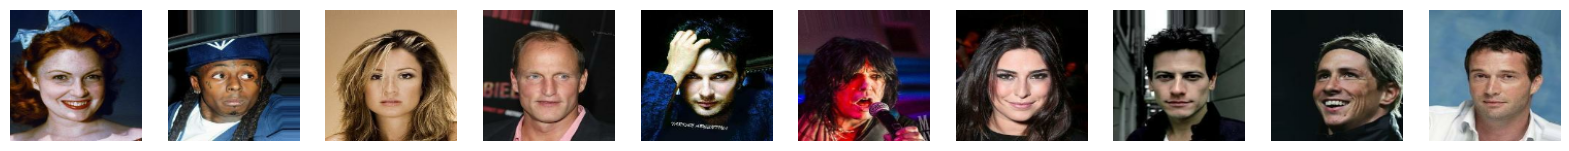

Reconstructions


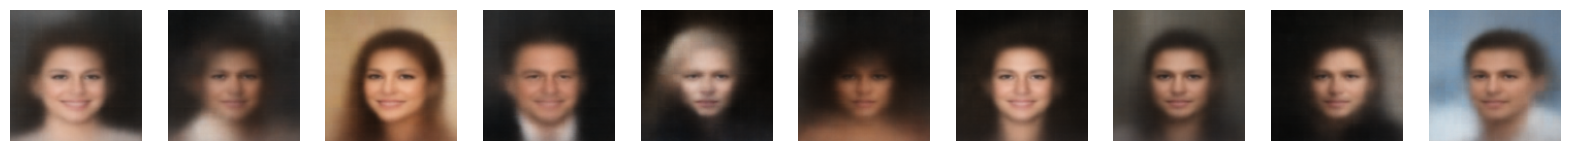

In [18]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Latent space distribution

2/2 [==============================] - 0s 5ms/step


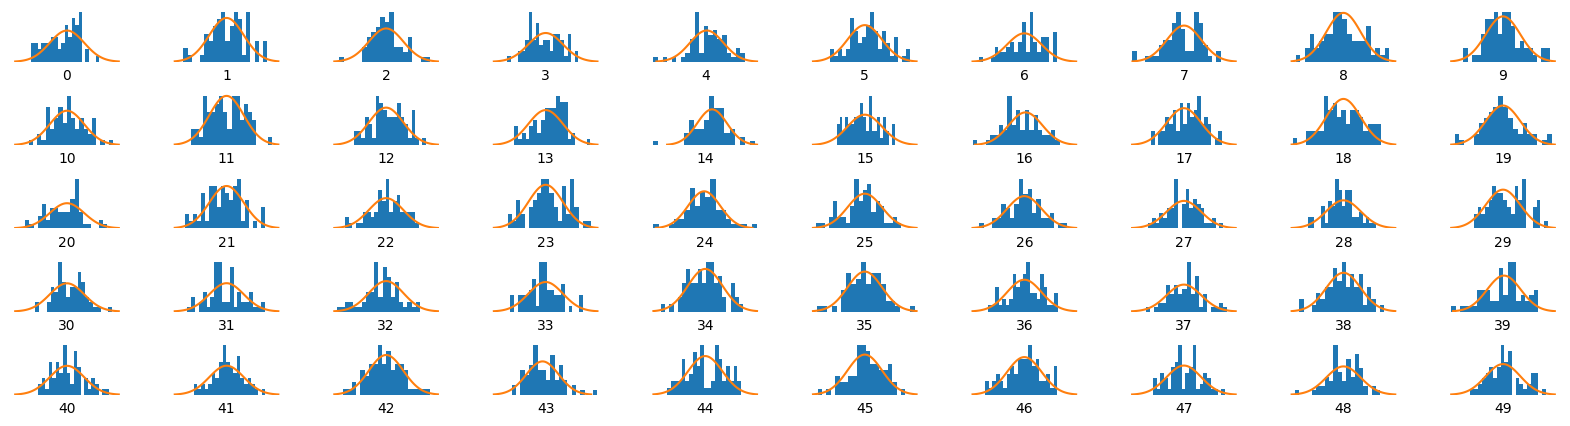

In [19]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## 5. Generate new faces <a name="decode"></a>

In [20]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [21]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 361ms/step


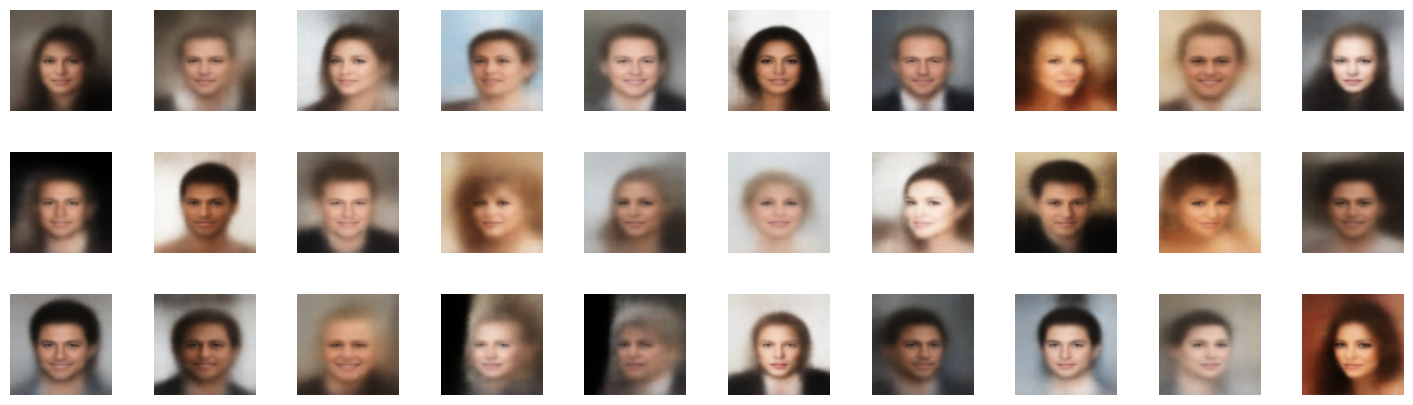

In [22]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. Manipulate the images <a name="manipulate"></a>

In [23]:
# Load the label dataset
attributes = pd.read_csv("/media/roger/Datos/asignaturas_master/tfm/datasetCelebA/archive/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [24]:
# Load the face data with label attached
LABEL = "Blond_Hair"  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
    "/media/roger/Datos/asignaturas_master/tfm/datasetCelebA/archive/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 1 classes.
Using 40519 files for validation.


In [25]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
11    : 4.194    : 1.985    : 4.715    : 4.715
19    : 2.701    : 1.408    : 3.846    : -0.869
31    : 2.129    : 0.794    : 3.055    : -0.791
42    : 1.254    : 0.566    : 2.668    : -0.387
52    : 0.962    : 0.436    : 2.307    : -0.361
62    : 0.688    : 0.344    : 2.246    : -0.06
76    : 0.74    : 0.271    : 2.147    : -0.099
87    : 0.593    : 0.265    : 2.099    : -0.048
97    : 0.507    : 0.235    : 2.084    : -0.015
102    : 0.324    : 0.237    : 2.055    : -0.029
112    : 0.398    : 0.191    : 2.029    : -0.026
122    : 0.409    : 0.175    : 2.015    : -0.014
134    : 0.418    : 0.151    : 1.983    : -0.032
143    : 0.309    : 0.144    : 1.962    : -0.021
154    : 0.289    : 0.137    : 1.924    : -0.038
163    : 0.236    : 0.135    : 1.926    : 0.002
168    : 0.188    : 0.111    : 1.906    : -0.019
176    : 0.215    : 0.12    : 1.904    : -0.002
186    : 0.25    : 0.101    : 1.873    : -0.031
197    : 0.236

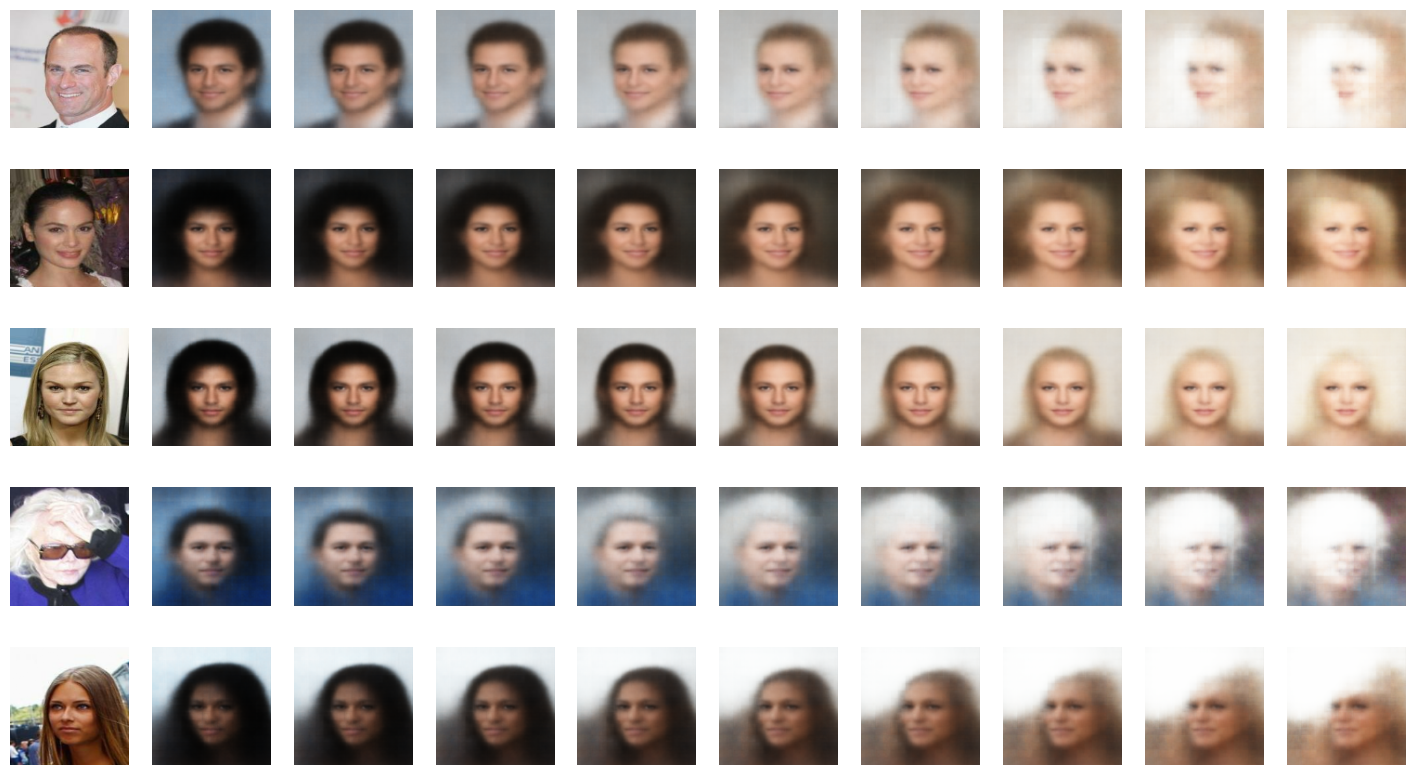

In [26]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)

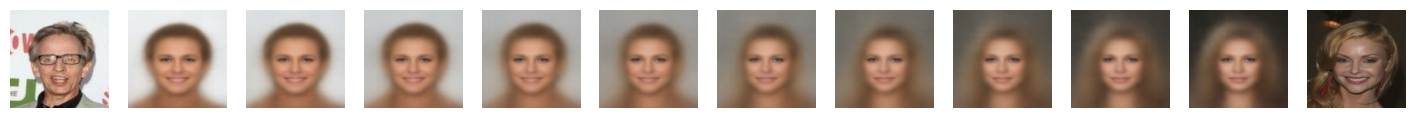

In [27]:
morph_faces(labelled, vae)